## Using climate4R framework with a Tidyverse twist
[What is climate4R?](https://github.com/SantanderMetGroup/climate4R) \
[What is Tidyverse?](https://www.tidyverse.org/)

In [1]:
# you can load the individual libraries or simple source the CAVA Analytics file
library(loadeR)
library(tidyverse)
library(rnaturalearth)
library(sf)
library(raster)
Sys.setenv("PROJ_LIB" = "/opt/conda/envs/fao/share/proj") # needed to visualize sf objects

Loading required package: rJava

Loading required package: loadeR.java

Java version 17x amd64 by N/A detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.4 (2022-06-15) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.7.1 (2021-07-05) is loaded

Please use 'citation("loadeR")' to cite this package.

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Warning message:
“Failed to locate timezone database”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks 

,min,max
x,21.825293,38.60947
y,8.665625,22.20244


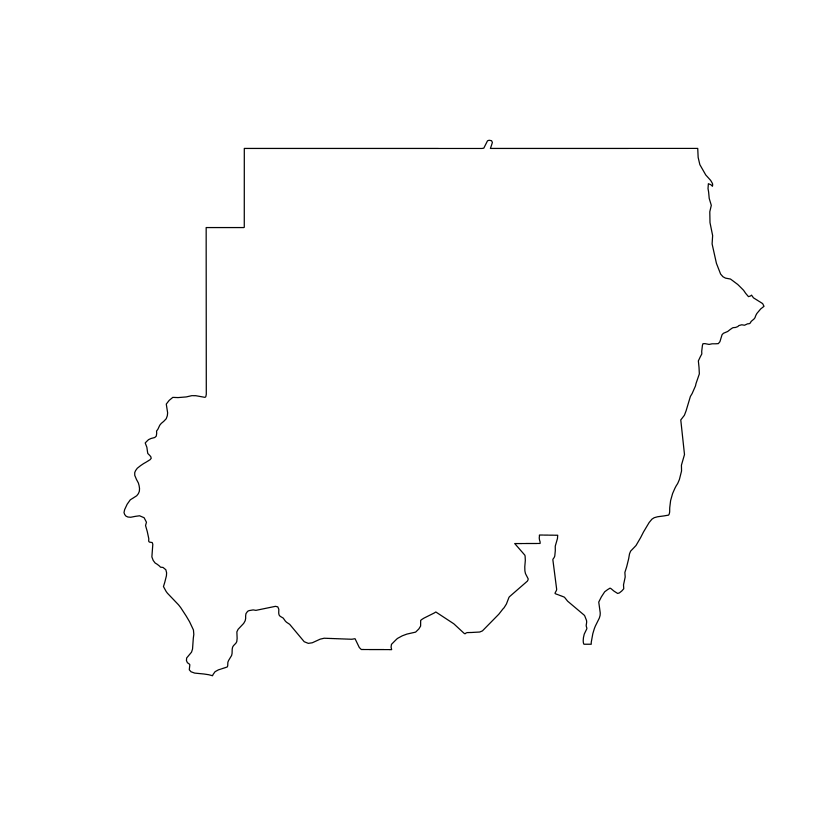

In [2]:
### Loading netcdf files ###
# In this example let's look at daily precipitation values for Togo
# If you know the coordinates, then it is fine, just use them, otherwise you can always download the country shape file
country_shp <- ne_countries(country="Sudan", scale = "medium")
plot(country_shp)
# coordinates can be found in the bbox slot
country_shp@bbox

In [3]:
# understanding the variables and time frame vailable 
# run this in your session
# dataInventory("/home/jovyan/shared/data/observations/W5E5/v1.0//w5e5_v1.0.ncml")

In [106]:
# loading precipitatin values for togo, W5E5 data
country_pr <- loadGridData("/home/jovyan/shared/data/observations/W5E5/v1.0//w5e5_v1.0.ncml", var = "pr", 
                        lonLim = c(20,39), latLim = c(7,23), year=1995)

[2023-03-17 11:07:53] Defining geo-location parameters

[2023-03-17 11:07:53] Defining time selection parameters

[2023-03-17 11:07:53] Retrieving data subset ...

Warning message in with_tz.default(x, tz):
“Unrecognized time zone 'GMT'”
[2023-03-17 11:07:57] Done



In [108]:
# let's explore the output of the loadGridData function. You can use this function to load and open any netCDF file
class(country_pr) # the output of loadGridData is always a list
length(country_pr) # the output of loadGridData is always of length 4 
names(country_pr) # the output of loadGridData always contains VAriable, Data, xyCoords and Dates
country_pr$Variable
country_pr$xyCoords
head(country_pr$Dates$start)
length(country_pr$Dates$start)
dim(country_pr$Data) # this is an array with 3 dimenions


[1] "list"

[1] 4

[1] "Variable" "Data"     "xyCoords" "Dates"

$varName
[1] "pr"

$level
NULL

attr(,"use_dictionary")
[1] FALSE
attr(,"description")
[1] "Precipitation"
attr(,"units")
[1] "kg m-2"
attr(,"longname")
[1] "pr"
attr(,"daily_agg_cellfun")
[1] "none"
attr(,"monthly_agg_cellfun")
[1] "none"
attr(,"verification_time")
[1] "none"

$x
 [1] 20.25 20.75 21.25 21.75 22.25 22.75 23.25 23.75 24.25 24.75 25.25 25.75
[13] 26.25 26.75 27.25 27.75 28.25 28.75 29.25 29.75 30.25 30.75 31.25 31.75
[25] 32.25 32.75 33.25 33.75 34.25 34.75 35.25 35.75 36.25 36.75 37.25 37.75
[37] 38.25 38.75 39.25

$y
 [1]  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25 10.75 11.25 11.75 12.25
[13] 12.75 13.25 13.75 14.25 14.75 15.25 15.75 16.25 16.75 17.25 17.75 18.25
[25] 18.75 19.25 19.75 20.25 20.75 21.25 21.75 22.25 22.75

attr(,"projection")
[1] "LatLonProjection"
attr(,"resX")
[1] 0.5
attr(,"resY")
[1] 0.5

[1] "1995-01-01 00:00:00 GMT" "1995-01-02 00:00:00 GMT"
[3] "1995-01-03 00:00:00 GMT" "1995-01-04 00:00:00 GMT"
[5] "1995-01-05 00:00:00 GMT" "1995-01-06 00:00:00 GMT"

[1] 365

[1] 365  33  39

## Visualizing the results (make a raster and plot with ggplot)

[1] 33 39

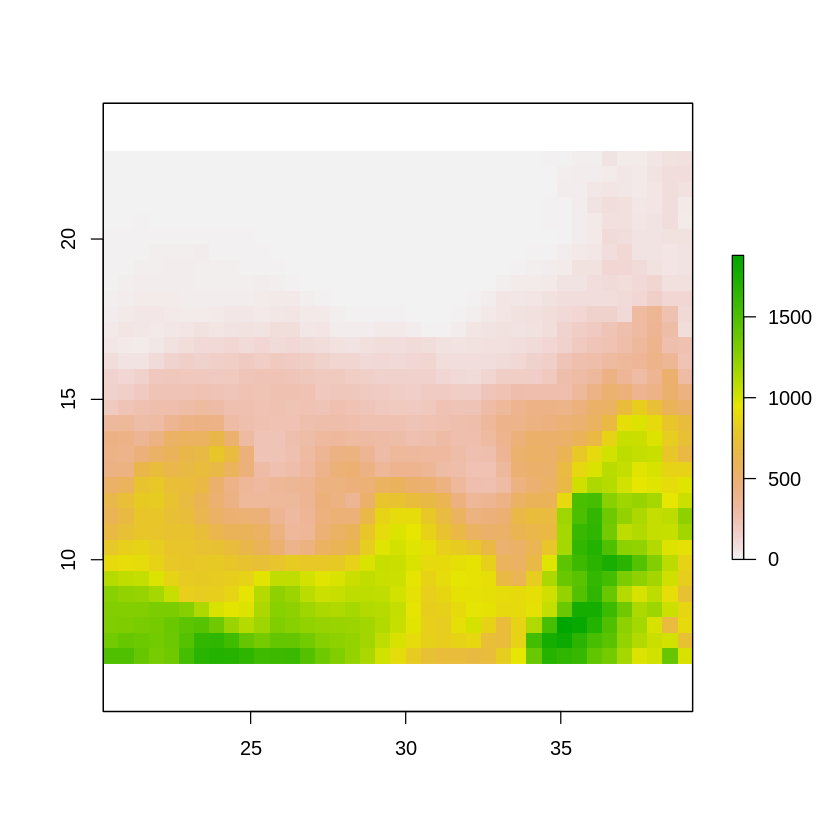

In [117]:
# to make a raster we need the data and an extent
# getting the data
mean_array <- apply(country_pr$Data, c(2,3), "sum", na.rm=T) # what are we doing here?
dim(mean_array)
# getting the extent
x  <-  country_pr$xyCoords$x
y <- country_pr$xyCoords$y

rst <- raster(mean_array, xmn=min(x), xmx=max(x), ymn=min(y), ymx=max(y)) %>%
    raster::flip(., direction = 'y') # always needed. This is due to how loadGridData uplad the data

plot(rst)


## Let's use ggplot2

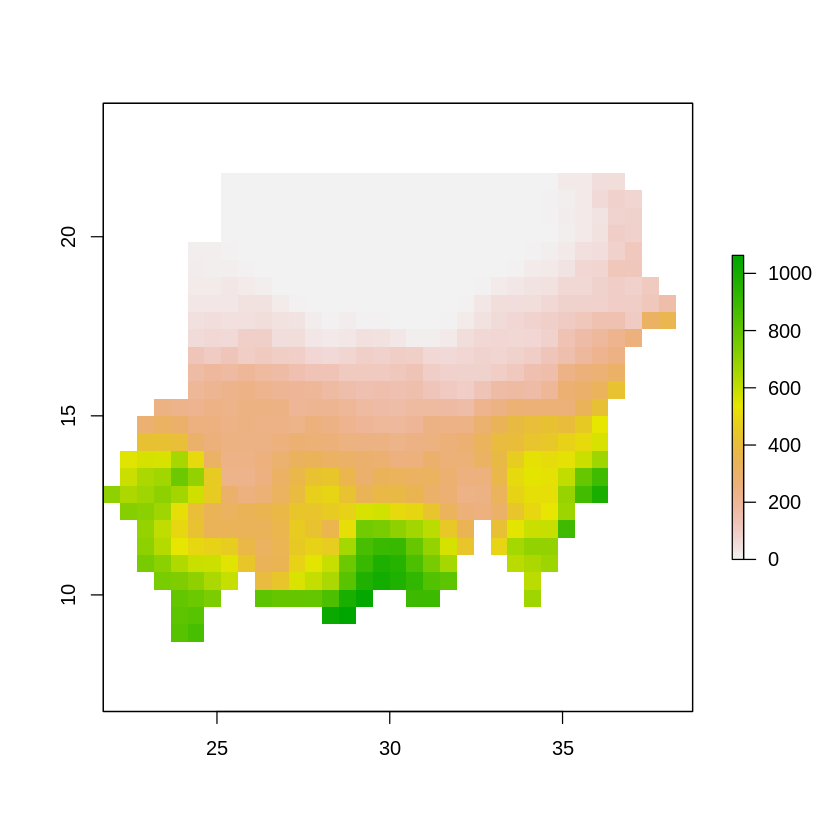

In [118]:
# how do we plot a raster?
# first we crop the raster according to the country shape file
rst_country <- rst %>% 
crop(., country_shp, snap = "out") %>% # crop
mask(., country_shp) # mask

plot(rst_country)


## Plotting a basic map with ggplot and geom_sf

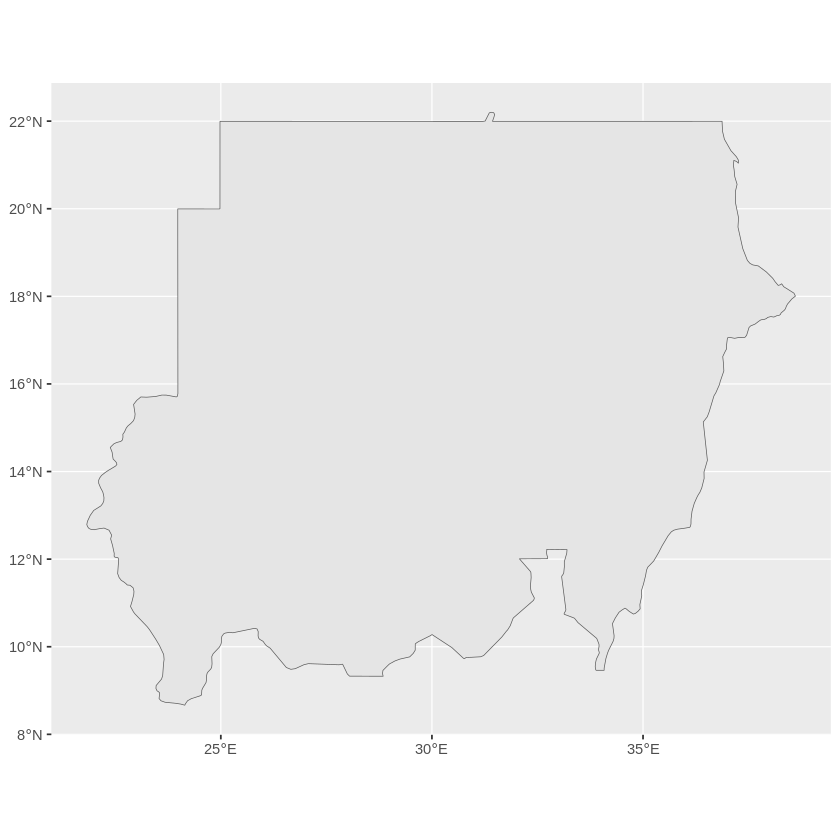

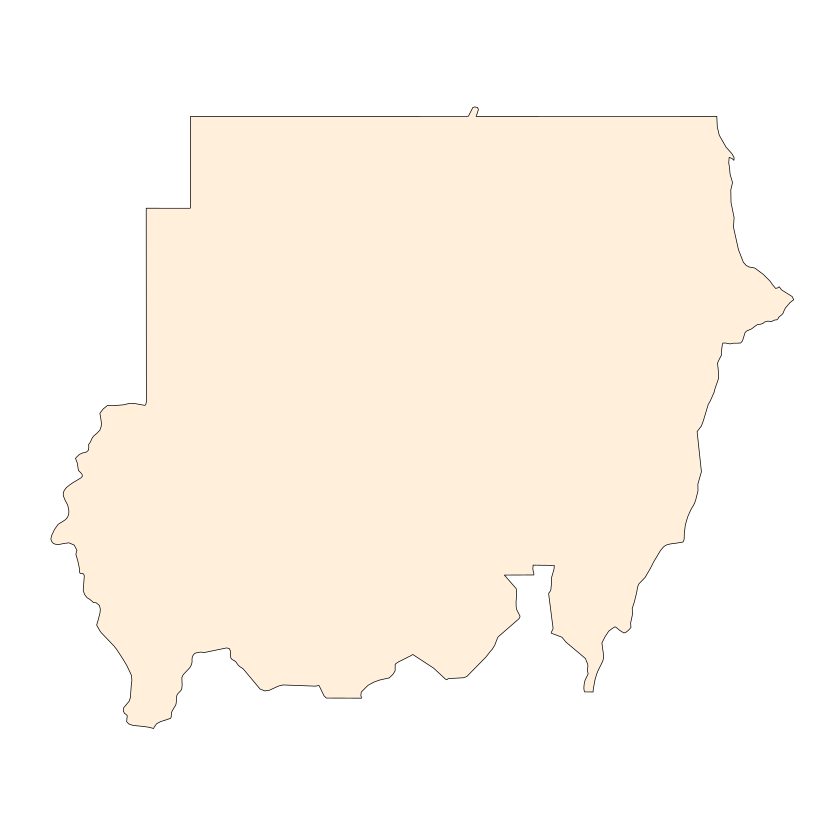

In [119]:
country_shp <- ne_countries(country="Sudan", scale = "medium", returnclass = "sf") # notice the returnclass argument 

# basic map
ggplot()+
geom_sf(data=country_shp)

# nicer
bs_map <- ggplot()+
geom_sf(fill = 'antiquewhite1',
        color = "black", data=country_shp)

# even nicer
bs_map2 <- bs_map +
 theme( panel.background = element_blank(),
        panel.border = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank())

bs_map2


In [120]:
# convert to df, necessary for plotting with ggplot2

rst_df <- raster::as.data.frame(rst_country, xy=T)
head(rst_df)


,x,y,layer
,<dbl>,<dbl>,<dbl>
1,21.95513,22.02273,NA
2,22.44231,22.02273,NA
3,22.92949,22.02273,NA
4,23.41667,22.02273,NA
5,23.90385,22.02273,NA
6,24.39103,22.02273,NA


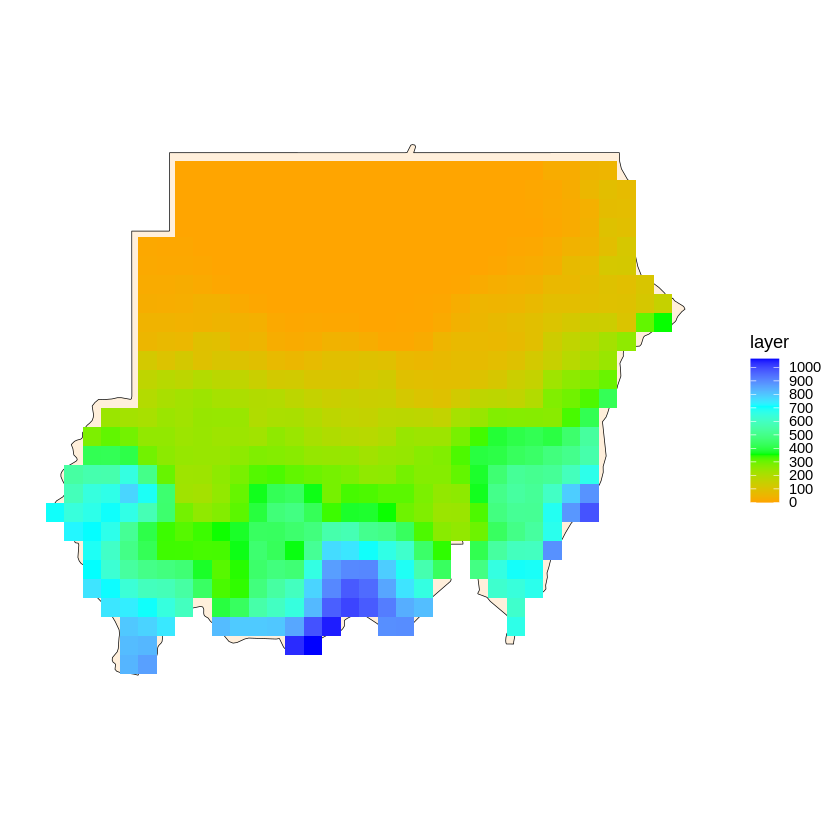

In [128]:
bs_map3 <- bs_map2+
geom_raster(aes(x=x, y=y,fill=layer), data=rst_df)+
scale_fill_gradientn(
        colors = c("orange", "green", "cyan", "blue"),
        na.value = "transparent",
        n.breaks = 10)
bs_map3 


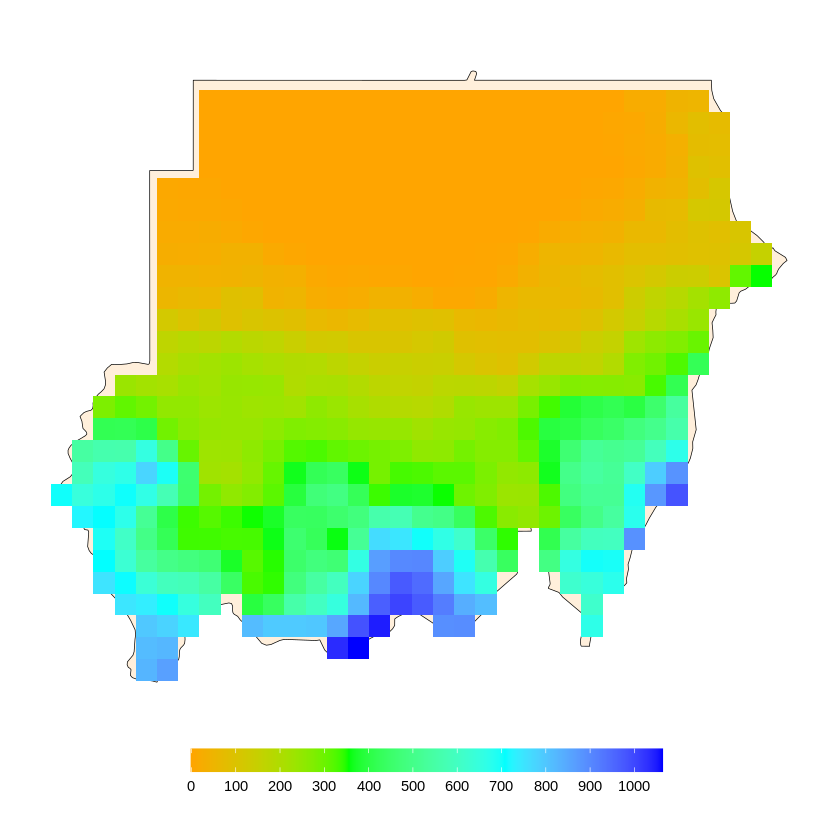

In [129]:
bs_map3 +
 theme(legend.position = "bottom",
        legend.direction = "horizontal",
        legend.key.height = unit(0.5, 'cm'),
        legend.key.width = unit(2, 'cm'),
        legend.box.spacing = unit(0, "pt"),
        legend.title=element_blank()
      )



# Unlocking Tidyverse with climate4R (simpler approach)

In [164]:
# let's plot total annual precipitation in Sudan for 1990, 2000 and 2010 combining tidyverse with climate4R
country_sp <- ne_countries(country="Sudan", scale = "medium")

year <- c(1990, 2000, 2010)

dataset= "/home/jovyan/shared/data/observations/W5E5/v1.0//w5e5_v1.0.ncml" # W5e5 dataset

# the map function is like a for loop but now we are using functional programming
country_years <- map(year, function(yrs) {
    
 c4r <- loadGridData(dataset, years = yrs, var="pr",  lonLim = c(20,39), latLim = c(7,23))
    
})


[2023-03-17 12:45:14] Defining geo-location parameters

[2023-03-17 12:45:14] Defining time selection parameters

[2023-03-17 12:45:14] Retrieving data subset ...

Warning message in with_tz.default(x, tz):
“Unrecognized time zone 'GMT'”
[2023-03-17 12:45:18] Done

[2023-03-17 12:45:18] Defining geo-location parameters

[2023-03-17 12:45:18] Defining time selection parameters

[2023-03-17 12:45:18] Retrieving data subset ...

Warning message in with_tz.default(x, tz):
“Unrecognized time zone 'GMT'”
[2023-03-17 12:45:23] Done

[2023-03-17 12:45:23] Defining geo-location parameters

[2023-03-17 12:45:23] Defining time selection parameters

[2023-03-17 12:45:23] Retrieving data subset ...

Warning message in with_tz.default(x, tz):
“Unrecognized time zone 'GMT'”
[2023-03-17 12:45:27] Done



In [138]:
# now we have a list which contains further lists
class(country_years)
length(country_years)
length(country_years[[1]]) # this owuld be the data for 1990

[1] "list"

[1] 3

[1] 4

In [165]:
# how do we create a raster for total annual rainfall for each year?
# first we make a function to make a raster out of a C4R list. To nake a raster we need

#rst <- raster(C4R$Data, xmx=max(C4R$xyCoords$x), xmn=min(C4R$xyCoords$x), ymx=max(C4R$xyCoords$y), ymn= min(C4R$xyCoords$x)) %>% 
#flip(., direction="y")

# However, data needs ot be a 2D matrix not an array. Thus:

#C4R$Data <- apply(C4R$Data, c(2,3), "sum", na.rm=T)

#rst <- raster(C4R$Data, xmx=max(C4R$xyCoords$x), xmn=min(C4R$xyCoords$x), ymx=max(C4R$xyCoords$y), ymn= min(C4R$xyCoords$y)) %>% 
#flip(., direction="y")

# Now we write the function

make_raster <- function(C4R) {
 
C4R$Data <- apply(C4R$Data, c(2,3), "sum", na.rm=T)

rst <- raster(C4R$Data, xmx=max(C4R$xyCoords$x), xmn=min(C4R$xyCoords$x), ymx=max(C4R$xyCoords$y), ymn= min(C4R$xyCoords$y)) %>% 
flip(., direction="y")
    
# now we crop
rst_cr <- rst %>% 
    crop(., country_sp) %>% 
    mask(., country_sp)
    
return(rst_cr)
    
}


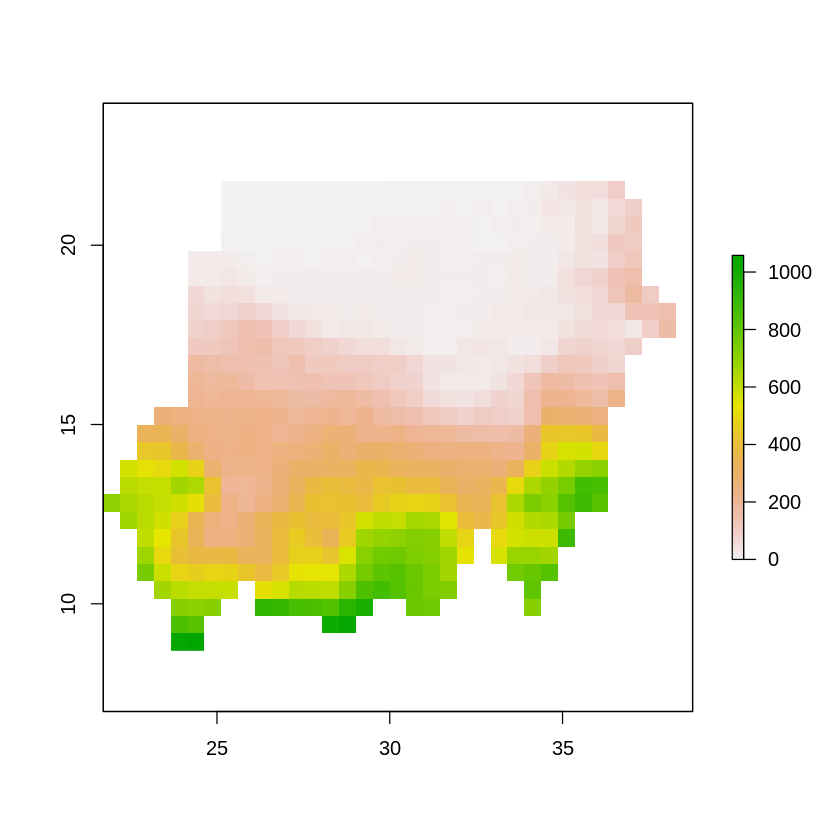

In [166]:
# Now we can apply the function using map

rsts <- map(country_years, make_raster) # list containing all the rasters

plot(rsts[[3]])

In [167]:
# Let's use ggplot now
df_rsts <- as.data.frame(stack(rsts), xy=T) # stack allow us to create a raster stack
head(df_rsts)


,x,y,layer.1,layer.2,layer.3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,21.95513,22.02273,NA,NA,NA
2,22.44231,22.02273,NA,NA,NA
3,22.92949,22.02273,NA,NA,NA
4,23.41667,22.02273,NA,NA,NA
5,23.90385,22.02273,NA,NA,NA
6,24.39103,22.02273,NA,NA,NA


In [168]:
# perform some transformation using dplyr 
df_rsts_gr <-  df_rsts %>% 
pivot_longer(cols = 3:5, names_to = "year", values_to = "total_pr")

head(df_rsts_gr)
df_rsts_gr <- df_rsts_gr  %>% 
mutate(year=case_when(year=="layer.1"~ 1990,
                     year=="layer.2" ~ 2000,
                     year=="layer.3" ~ 2010))
head(df_rsts_gr)

x,y,year,total_pr
<dbl>,<dbl>,<chr>,<dbl>
21.95513,22.02273,layer.1,NA
21.95513,22.02273,layer.2,NA
21.95513,22.02273,layer.3,NA
22.44231,22.02273,layer.1,NA
22.44231,22.02273,layer.2,NA
22.44231,22.02273,layer.3,NA


x,y,year,total_pr
<dbl>,<dbl>,<dbl>,<dbl>
21.95513,22.02273,1990,NA
21.95513,22.02273,2000,NA
21.95513,22.02273,2010,NA
22.44231,22.02273,1990,NA
22.44231,22.02273,2000,NA
22.44231,22.02273,2010,NA


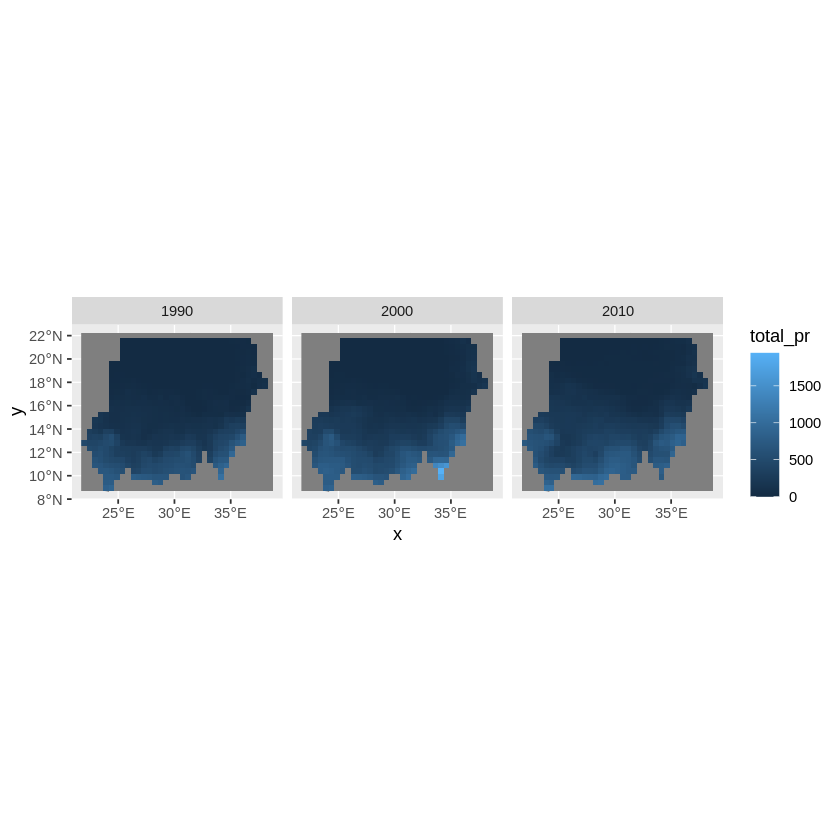

In [176]:
country_shp <- ne_countries(country="Sudan", scale = "medium", returnclass = "sf") # notice the returnclass argument 

# basic map
ggplot()+
geom_sf(data=country_shp)+
geom_raster(aes(x=x, y=y, fill=total_pr), data=df_rsts_gr)+
facet_grid(~year)

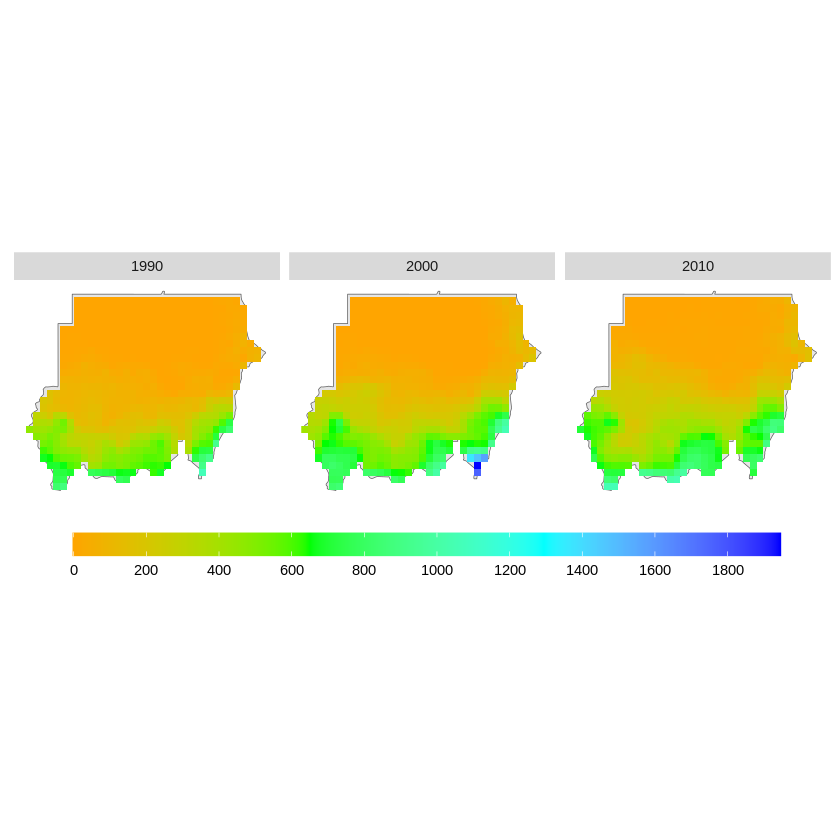

In [178]:
# Improve the layout
ggplot()+
geom_sf(data=country_shp)+
geom_raster(aes(x=x, y=y, fill=total_pr), data=df_rsts_gr)+
facet_grid(~year)+
scale_fill_gradientn(
        colors = c("orange", "green", "cyan", "blue"),
        na.value = "transparent",
        n.breaks = 10)+
 theme( panel.background = element_blank(),
        panel.border = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        legend.position="bottom", 
        legend.key.height = unit(0.5, 'cm'),
        legend.key.width = unit(3, 'cm'), 
        legend.title=element_blank())

## Other resources to maps in R
- [leaflet](https://rstudio.github.io/leaflet/)
- [tmap](https://cran.r-project.org/web/packages/tmap/vignettes/tmap-getstarted.html)

# Now is your turn =)

## First exercise
- Plot the overall total precipitation for 2010 in Cabo Verde

## More advanced

- Plot the overall total precipitation for 1980, 2000 and 2010 in Cabo Verde